In [1]:
from typing import Union, List
from PIL import Image
from tqdm import tqdm

import torch
import diffusers

In [2]:
pipe = diffusers.StableDiffusionImageVariationPipeline.from_pretrained(
  "lambdalabs/sd-image-variations-diffusers",
  torch_dtype=torch.float16,
  revision="v2.0",
).to("cuda" if torch.cuda.is_available() else "cpu")

print(pipe)
print("Device:", pipe.device)

image_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


StableDiffusionImageVariationPipeline {
  "_class_name": "StableDiffusionImageVariationPipeline",
  "_diffusers_version": "0.20.2",
  "_name_or_path": "lambdalabs/sd-image-variations-diffusers",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Device: cuda:0


(512, 512)


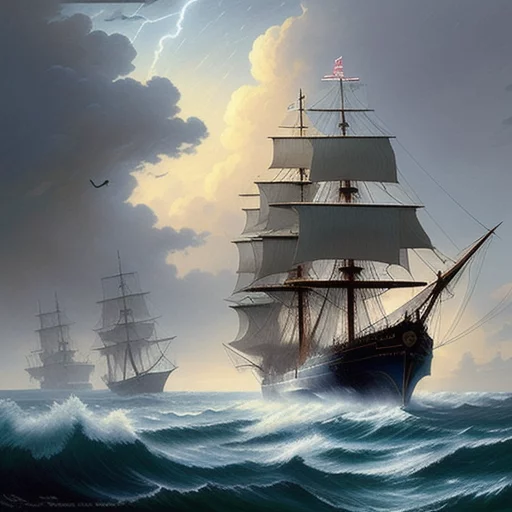

In [3]:
image= diffusers.utils.load_image("https://stablediffusion.fr/assets/seascape/2-painting,%20science%20fiction,%20fran%C3%A7ois%20balanger%20style,%20high%20seas,%20antique%20sailing%20ship,%20storm,%20storm%20light,%20spaceship,%20birds.webp")

print(image.size)
image

In [4]:
# Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionImageVariationPipeline.encode_image
def encode_image(image, device, num_images_per_prompt, do_classifier_free_guidance):
    dtype = next(pipe.image_encoder.parameters()).dtype

    if not isinstance(image, torch.Tensor):
        image = pipe.feature_extractor(images=image, return_tensors="pt").pixel_values

    image = image.to(device=device, dtype=dtype)
    image_embeddings = pipe.image_encoder(image).image_embeds
    image_embeddings = image_embeddings.unsqueeze(1)

    # duplicate image embeddings for each generation per prompt, using mps friendly method
    bs_embed, seq_len, _ = image_embeddings.shape
    image_embeddings = image_embeddings.repeat(1, num_images_per_prompt, 1)
    image_embeddings = image_embeddings.view(bs_embed * num_images_per_prompt, seq_len, -1)

    if do_classifier_free_guidance:
        negative_prompt_embeds = torch.zeros_like(image_embeddings)

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        image_embeddings = torch.cat([negative_prompt_embeds, image_embeddings])

    return image_embeddings

In [5]:
# image_embeddings = encode_image(image, pipe.device, 1, False)
# print(image_embeddings.shape)

# image_embeddings = encode_image(image, pipe.device, 1, True)
# print(image_embeddings.shape)

In [6]:
# Modified from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionImageVariationPipeline.__call__
height, width = image.size

guidance_scale: float = 7.5
num_inference_steps: int = 30
num_images_per_prompt: int = 1

# here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
# of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
# corresponds to doing no classifier free guidance.
do_classifier_free_guidance = guidance_scale > 1.0

# 3. Encode input image
image_embeddings = encode_image(
    image,
    pipe.device,
    num_images_per_prompt,
    do_classifier_free_guidance,
)

# 4. Prepare timesteps
pipe.scheduler.set_timesteps(num_inference_steps, device=pipe.device)
timesteps = pipe.scheduler.timesteps

# 5. Prepare latent variables
latents_shape = (
    len(image) if isinstance(image, list) else 1,
    pipe.unet.config.in_channels,
    height // pipe.vae_scale_factor,
    width // pipe.vae_scale_factor,
)
latents = diffusers.utils.randn_tensor(
    latents_shape, generator=None, device=pipe.device, dtype=image_embeddings.dtype
)
# scale the initial noise by the standard deviation required by the scheduler
latents = latents * pipe.scheduler.init_noise_sigma

# 7. Denoising loop
for i, t in tqdm(enumerate(timesteps)):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = (
        torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    )
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    noise_pred = pipe.unet(
        latent_model_input, t, encoder_hidden_states=image_embeddings
    ).sample

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        )

    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

image_out = pipe.vae.decode(
    latents / pipe.vae.config.scaling_factor,
    return_dict=False,
)[0]

image_out = pipe.image_processor.postprocess(
    image_out,
    output_type="pil",
    do_denormalize=[True] * image_out.shape[0],
)

1it [00:02,  2.89s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 47.54 GiB total capacity; 5.91 GiB already allocated; 11.56 MiB free; 5.93 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF